<a href="https://colab.research.google.com/github/lorenzkuhn/advi/blob/main/ARD.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [14]:
!pip3 install pyro-ppl tqdm

In [10]:
import torch
from torch import nn

import pyro
from pyro.nn import PyroModule
from pyro.nn import PyroSample
from pyro.infer import MCMC, NUTS, HMC, Predictive
from pyro.infer.autoguide import AutoDiagonalNormal
from pyro.infer.autoguide import AutoContinuous
from pyro.infer import SVI, Trace_ELBO
import pyro.distributions as dist
from torch.distributions import constraints

import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import time
from tqdm.notebook import tqdm, trange

In [3]:
# Making training data
# Adopted from https://github.com/julianroth/ADVI/blob/master/ard_experiment.py

def make_training_data(num_samples, dims, sigma, mu=0):
  """
  Creates training data when half of the regressors are 0
  """
  x = np.random.randn(num_samples, dims).astype(np.float64)
  w = sigma * np.random.randn(1,dims).astype(np.float64)
  noise = np.random.normal(0, 5, num_samples).astype(np.float64).reshape(-1,1)
  #noise = 0
  w[:,:int(dims/2)] = 0.
  y = np.matmul(x, w.T) + (noise/2) + mu

  y = torch.tensor(y, dtype = torch.float)
  x = torch.tensor(x, dtype = torch.float)
  return y, x, w


def sep_training_test(y,x,test):
  y_train = y[test:,:]
  x_train = x[test:,:]
  
  y_test = y[:test,:]
  x_test = x[:test,:]
  return y_train, y_test, x_train, x_test

In [4]:
# Define the bayesian model in pyro
def model(x, y=None):
      num_features = x.shape[1]

      alpha = pyro.sample('alpha', dist.Gamma(torch.tensor([1.0]), torch.tensor([1.0])).expand([num_features]).to_event(1))
      one_over_sqrt_alpha = 1/torch.sqrt(alpha)

      sigma2 = pyro.sample('sigma2', dist.InverseGamma(torch.tensor([1.0]), torch.tensor([1.0])))
      sigma = torch.sqrt(sigma2)

      beta = pyro.sample('beta', dist.Normal(torch.tensor([0.0]), sigma*one_over_sqrt_alpha).expand([num_features]).to_event(1))

      mean = torch.matmul(x, beta)

      with pyro.plate("data", x.shape[0]):          
          outcome_dist = dist.Normal(mean, sigma)          
          observation = pyro.sample("obs", outcome_dist, obs=y)

In [18]:
def run_advi(model, num_iterations, num_particles, verbose = False):
  # Define the ADVI components: Guide, Optimizer and SVI
  torch.manual_seed(0)

  guide = AutoDiagonalNormal(model)
  adaprop = pyro.optim.AdagradRMSProp(dict())
  svi = SVI(model, guide, adaprop, loss=Trace_ELBO(num_particles = num_particles))

  # Run ADVI 
  pyro.clear_param_store()

  output_advi = pd.DataFrame(columns = ["t", "test_accuracy", "model"])

  step_ids = []
  step_time = []
  average_log_predictives = []
  mse_loss = nn.MSELoss()
  train_time = 0

  sample_size_l = np.arange(1500, 20000, 1000)
  sample_size_s = np.arange(0, 1500, 100)
  sample_size = np.concatenate((sample_size_s, sample_size_l))

  for j in tqdm(range(num_iterations)):
      # calculate the loss and take a gradient step
      t0 = time.time()
      loss = svi.step(x_train, y_train.squeeze())
      t1 = time.time()
      train_time += (t1-t0)     

      if j in sample_size: #Evaluate model every 1000 samples
        learned_beta = guide.median()['beta']
        learned_sigma2 = guide.median()['sigma2']

        mean = torch.matmul(x_test, learned_beta)
        sigma = torch.sqrt(learned_sigma2)

        norm_dist = dist.Normal(mean, sigma)
        test_log_prob = norm_dist.log_prob(y_test.squeeze()).sum()
        test_log_prob /= len(y_test)

        output_iter = {"t":train_time,
                      "test_accuracy":test_log_prob.detach().numpy(),
                      "model":"advi_" + str(num_particles)}

        output_advi = output_advi.append(output_iter, ignore_index = True)
        if verbose == True: print("[iteration %04d] loss: %.4f" % (j + 1, test_log_prob))  
        
  return output_advi

In [20]:
def run_mcmc(model):
  # Run MCMC using Stan kernel
  pyro.clear_param_store()
  torch.manual_seed(0)

  test_log_prob_list = []
  train_time = []

  def hook_fn(kernel, sample, stage, i):
      #use the most recently sampled param to estimate performance
      if i < 100 or (i % 50 == 0): #evaluate all first 100 samples and then every 50
        learned_beta = sample['beta']
        learned_sigma2 = torch.exp(sample['sigma2']) #ATTENTION: InvGamma uses PowerTransform
        
        mean = torch.matmul(x_test, learned_beta)
        sigma = torch.sqrt(learned_sigma2)

        norm_dist = dist.Normal(mean, sigma)
        test_log_prob = torch.sum(norm_dist.log_prob(y_test.squeeze()))
        test_log_prob /= len(y_test)

        train_time.append(time.time())    
        test_log_prob_list.append(test_log_prob)

  nuts_kernel = NUTS(model, max_tree_depth = 4)

  nuts = MCMC(
              nuts_kernel,
              num_samples=300,
              warmup_steps=300,
              disable_progbar=False,
              num_chains = 1,
              hook_fn = hook_fn
      ) 

  nuts.run(x_train, y_train.squeeze())

  output_nuts = pd.DataFrame({'t':np.array(train_time)-train_time[0], 
                              "test_accuracy":np.array(test_log_prob_list),
                              "model":"nuts"})
  
  return output_nuts

Running ADVI with M = 1


  0%|          | 0/10000 [00:00<?, ?it/s]

Running ADVI with M = 10


  0%|          | 0/10000 [00:00<?, ?it/s]

Running MCMC with Stan kernel


Sample: 100%|██████████| 600/600 [00:51, 11.76it/s, step size=3.58e-01, acc. prob=0.812]


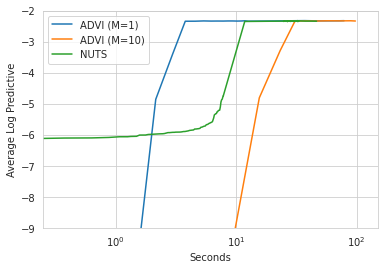

In [21]:
# Simulate the data:
num_features = 250
y, x, w = make_training_data(11000, num_features, 10, mu=0)
y_train, y_test, x_train, x_test = sep_training_test(y,x,1000)

# Train the ADVI models
print('Running ADVI with M = 1')
output_advi_M1 = run_advi(model, 10000, 1)
print('Running ADVI with M = 10')
output_advi_M10 = run_advi(model, 3000, 10)

# Train the MCMC models 
print('Running MCMC with NUTS kernel')
output_nuts = run_mcmc(model)

# Generate plot (Figure 4 in original paper)
output = output_advi_M1.append(output_advi_M10, ignore_index=True)
output = output.append(output_nuts, ignore_index = True)
output = output.loc[output['t'] < 100]
output['test_accuracy'] = output['test_accuracy'].astype('float')

sns.set_style("whitegrid")
results = sns.lineplot(data = output, x = 't', y = 'test_accuracy', hue = 'model')
results.set(xscale='log', 
            xlim = (0.25, 150), 
            ylim = (-9, -2),
            xlabel = 'Seconds',
            ylabel = 'Average Log Predictive')
plt.legend(labels=["ADVI (M=1)","ADVI (M=10)", "NUTS"])